In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import lime
import lime.lime_tabular

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

creditcard.csv



In my previous kernel for this dataset, I performed exploratory data analysis and built a basic logistic regression model to get a first glimpse of what is the best approach to detect the anomalies. We saw that using a simple supervised classification model without applying upsampling/downsampling of the majority class (recall dataset is imbalanced), the AUCPR was really low. Thus, we need to find another strategy.
Recall we saw that for both non-fraudulent and fraudlent classes, features followed Gaussian distributions. For example, for V4, the non-fraudulent class followed a Gaussian distribution with small variance compared to the fraudulent class. 

CPU times: user 13 s, sys: 21.3 s, total: 34.3 s
Wall time: 17.9 s


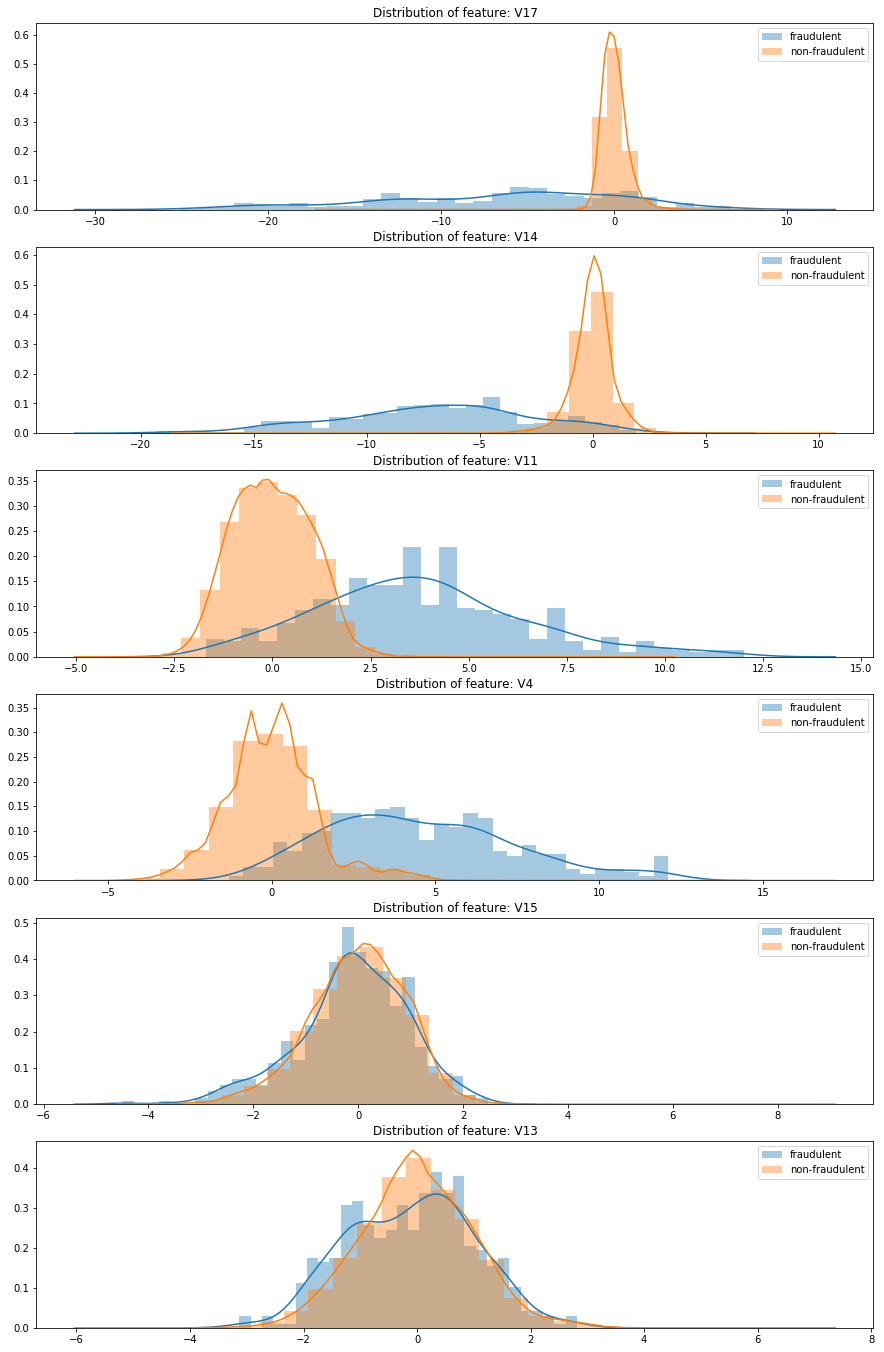

In [2]:
%%time
df = pd.read_csv('../input/creditcard.csv')

import matplotlib.gridspec as gridspec

features=['V17','V14', 'V11', 'V4', 'V15', 'V13']
nplots=np.size(features)
plt.figure(figsize=(15,4*nplots))
gs = gridspec.GridSpec(nplots,1)
for i, feat in enumerate(features):
    ax = plt.subplot(gs[i])
    sns.distplot(df[feat][df.Class==1], bins=30)
    sns.distplot(df[feat][df.Class==0],bins=30)
    ax.legend(['fraudulent', 'non-fraudulent'],loc='best')
    ax.set_xlabel('')
    ax.set_title('Distribution of feature: ' + feat)

Now let's evaluate the scatterplots between two features (i.e. V14 and V17, V11 and V4, etc...). We are trying to find what kind of Gaussian distributions we have (i.e. evaluate the covariances) so that we can estimate a Gaussian Mixture Model (GMM) using the Expectation-Maximization algorithm in order to represent the the non-fraudulent class. Finally, detect the fraudulent samples by evaluating their probabilities (i.e. below a threshold).


CPU times: user 981 ms, sys: 880 ms, total: 1.86 s
Wall time: 961 ms


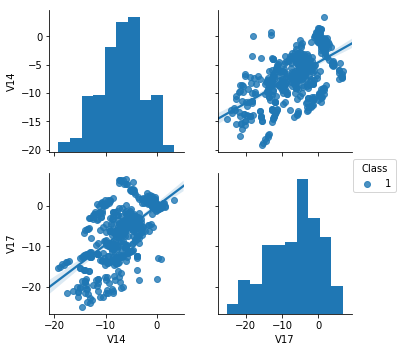

In [3]:
%%time
sns.pairplot(df[df.Class==1], vars=['V14', 'V17'], kind='reg', hue='Class')

Now we will train a simple Gaussian mixture model using V14 and V17. A Gaussian mixture model is a probabilistic model that assumes all the data points are generated from a mixture of a finite number of Gaussian distributions with unknown parameters. One can think of mixture models as generalizing k-means clustering to incorporate information about the covariance structure of the data as well as the centers of the latent Gaussians.

We will create a dataset with only non-fraudulent transactions and a dataset with fraudulent ones
Then we will plit non-fraudulent data in 90% for training GMM and 10% for cross-validation and testing
Then we will split the fraudulent data in 50% for cross-validation (to find the probability threshold) and 50% for testing.

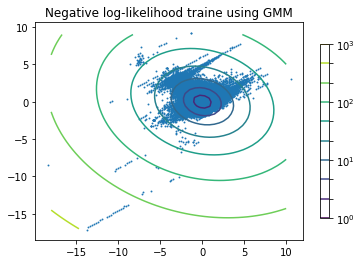

CPU times: user 2 s, sys: 1.29 s, total: 3.29 s
Wall time: 2.3 s


In [4]:
%%time
from sklearn.model_selection import train_test_split
from matplotlib.colors import LogNorm
from sklearn import mixture

df_0 = df[df.Class==0]    #Dataset with non-fraudulent only
df_1 = df[df.Class==1]    #Dataset with fraudulent only
df_0 = df_0[['V14', 'V17','Class']]    #Select two most correlated features for now
df_1 = df_1[['V14', 'V17', 'Class']]

#Split non-fraudulent data in 90% for training GMM and 10% for cross-validation and testing
X_train, X_test, y_train, y_test = train_test_split(df_0.drop(['Class'],axis=1), df_0['Class'] , test_size=0.1, random_state=0)

#Split the fraudulent data in 50% for cross-validation and 50% for testing
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(df_1.drop(['Class'],axis=1), df_1['Class'] , test_size=0.5, random_state=0)

# Fit a Gaussian Mixture Model with the two components 'V14' and 'V17'
gmm = mixture.GaussianMixture()
gmm.fit(X_train)

# display predicted scores by the model as a contour plot
x = np.linspace(-18, 10)
y = np.linspace(-17, 9.)
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T
Z = -gmm.score_samples(XX)
Z = Z.reshape(X.shape)
CS = plt.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0), levels=np.logspace(0, 3, 10))
CB = plt.colorbar(CS, shrink=0.8, extend='both')
plt.scatter(X_train['V14'].values,X_train['V17'].values, 0.8)
plt.title('Negative log-likelihood traing using GMM')
plt.axis('tight')
plt.show()

Now that the GMM is fit, let's find the probabilities of the test set. After we find those probabilities, if the probability is below a threshold we will say it is a fraudulent transaction (that is because our GMM is based on non-fraudulent transactions). Low probability means that is not probable that a given transaction is non-fraudulent.

CPU times: user 70.7 ms, sys: 1.97 ms, total: 72.6 ms
Wall time: 70.6 ms


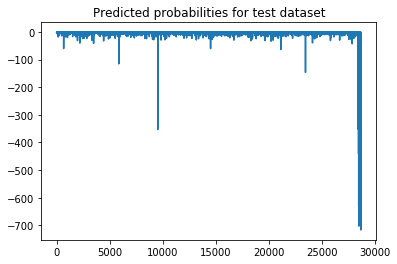

In [5]:
%%time
######### Cross-validation step to select best threshold T still to be done ####
#  KFold=...
#################################################################################
from sklearn.metrics import average_precision_score
y_test_proba = gmm.score_samples(np.vstack([X_test, X_test_1]))
plt.plot(y_test_proba)
plt.title('Predicted probabilities for test dataset')

We can see on the plot above that there are some pics of low probability. Those are probably outliers.
To make it correctly, we should find the threshold T by doing crossvalidation. 
Now, just to have a first impresion of how this works compared to the Logistic classifier from prevous sections, we will define a fixed threshold and evaluate the performance.

Note that we have gone from an AUCPR of 0.47 using Logistic classifier to an AUCPR of 0.67.
This will probably be improved more if we optimize the threshold T using cross-validation
and we use more features, not just 'V14' and 'V17'.
I will do this in soon... Keep 

In [6]:
from sklearn.metrics import classification_report, average_precision_score, f1_score, recall_score, precision_score
def print_classification_report(y_test, y_predic):
    print('Classification report:')
    print(classification_report(y_test, y_predic))

    print('Average Precision = ' + str(average_precision_score(y_test, y_predic)))

    print('\nBinary F1 Score, Recall and Precision:')
    f = f1_score(y_test, y_predic, average = "binary")
    Recall = recall_score(y_test, y_predic, average = "binary")
    Precision = precision_score(y_test, y_predic, average = "binary")
    print('F1 Score %f' %f)
    print('Recall Score %f' %Recall)
    print('Precision Score %f' %Precision)

    print('\nMicro F1 Score, Recall and Precision:')
    f = f1_score(y_test, y_predic, average = "micro")
    Recall = recall_score(y_test, y_predic, average = "micro")
    Precision = precision_score(y_test, y_predic, average = "micro")
    print('F1 Score %f' %f)
    print('Recall Score %f' %Recall)
    print('Precision Score %f' %Precision)

    print('\nMacro F1 Score, Recall and Precision:')
    f = f1_score(y_test, y_predic, average = "macro")
    Recall = recall_score(y_test, y_predic, average = "macro")
    Precision = precision_score(y_test, y_predic, average = "macro")
    print('F1 Score %f' %f)
    print('Recall Score %f' %Recall)
    print('Precision Score %f' %Precision)

In [7]:
%%time
T = -40
y_test_proba[y_test_proba >= T] = 0
y_test_proba[y_test_proba <  T] = 1

y_test_orig = np.hstack([y_test, y_test_1])

print_classification_report(y_test_orig, y_test_proba)

Classification report:
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     28432
          1       0.95      0.72      0.81       246

avg / total       1.00      1.00      1.00     28678

Average Precision = 0.6794231491534392

Binary F1 Score, Recall and Precision:
F1 Score 0.814815
Recall Score 0.715447
Precision Score 0.946237

Micro F1 Score, Recall and Precision:
F1 Score 0.997210
Recall Score 0.997210
Precision Score 0.997210

Macro F1 Score, Recall and Precision:
F1 Score 0.906705
Recall Score 0.857548
Precision Score 0.971890
CPU times: user 63.8 ms, sys: 0 ns, total: 63.8 ms
Wall time: 60.2 ms


In [8]:
%%time
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.as_matrix(), feature_names = X_train.columns,
                                                   class_names = ["0","1"], discretize_continuous = True)
exp = explainer.explain_instance(y_train.as_matrix(), gmm.predict_proba(y_train), num_features=2, top_labels=1)

ValueError: Expected 2D array, got 1D array instead:
array=[0. 0. 0. ... 0. 0. 0.].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.